In [44]:
#install lazypredict package
!pip install lazypredict

In [45]:
#import modules
import os
from copy import copy
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt; plt.rcdefaults()
import seaborn as sns
import scipy as sp
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.model_selection import train_test_split
import sklearn
from lazypredict.Supervised import LazyRegressor

In [46]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:
#load data
%reset df_coral
df_coral = pd.read_csv("/content/drive/MyDrive/global_bleaching_environmental.csv", low_memory=False)

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
Don't know how to reset  df_coral, please run `%reset?` for details


# My Data Cleaning
Based on the description in the Data Cleaning section of Madireddy, et al (2023).

In [48]:
df_coral['Date'] = pd.to_datetime(df_coral['Date'], format='mixed')
df_coral = df_coral.loc[pd.to_datetime(df_coral["Date"], format='mixed') > '12/31/2002']
df_coral.loc[:,'Year'] = df_coral['Date'].dt.strftime('%Y').astype(int)
df_coral = df_coral.replace('nd', 0)
df_coral = df_coral.loc[df_coral["SSTA"].astype(float) > 0]

In [49]:
df_coral.shape

(6112, 49)

In [50]:
numeric_columns = ['Latitude_Degrees', 'Longitude_Degrees', 'Depth',
       'ClimSST', 'Temperature_Kelvin', 'Temperature_Mean',
       'Temperature_Minimum', 'Temperature_Maximum',
       'Temperature_Kelvin_Standard_Deviation', 'Windspeed', 'SSTA',
       'SSTA_Standard_Deviation', 'SSTA_Mean', 'SSTA_Minimum', 'SSTA_Maximum',
       'SSTA_Frequency', 'SSTA_Frequency_Standard_Deviation',
       'SSTA_FrequencyMax', 'SSTA_FrequencyMean', 'SSTA_DHW',
       'SSTA_DHW_Standard_Deviation', 'SSTA_DHWMax', 'SSTA_DHWMean', 'TSA',
       'TSA_Standard_Deviation', 'TSA_Minimum', 'TSA_Maximum', 'TSA_Mean',
       'TSA_Frequency', 'TSA_Frequency_Standard_Deviation', 'TSA_FrequencyMax',
       'TSA_FrequencyMean', 'TSA_DHW', 'TSA_DHW_Standard_Deviation',
       'TSA_DHWMax', 'TSA_DHWMean', 'Average_Bleaching', 'Year']

df_coral = df_coral[numeric_columns].apply(pd.to_numeric)

In [51]:
print(df_coral.shape)
print(df_coral.dtypes)

(6112, 38)
Latitude_Degrees                         float64
Longitude_Degrees                        float64
Depth                                    float64
ClimSST                                  float64
Temperature_Kelvin                       float64
Temperature_Mean                         float64
Temperature_Minimum                      float64
Temperature_Maximum                      float64
Temperature_Kelvin_Standard_Deviation    float64
Windspeed                                  int64
SSTA                                     float64
SSTA_Standard_Deviation                  float64
SSTA_Mean                                  int64
SSTA_Minimum                             float64
SSTA_Maximum                             float64
SSTA_Frequency                           float64
SSTA_Frequency_Standard_Deviation        float64
SSTA_FrequencyMax                        float64
SSTA_FrequencyMean                       float64
SSTA_DHW                                 float64
SSTA_DHW_

# My Feature Selection
Based on the description in the Identifying Features of Interest section of Madireddy, et al (2023).

## Charting correlation coefficients (pearson)
This appears to replicate their results.

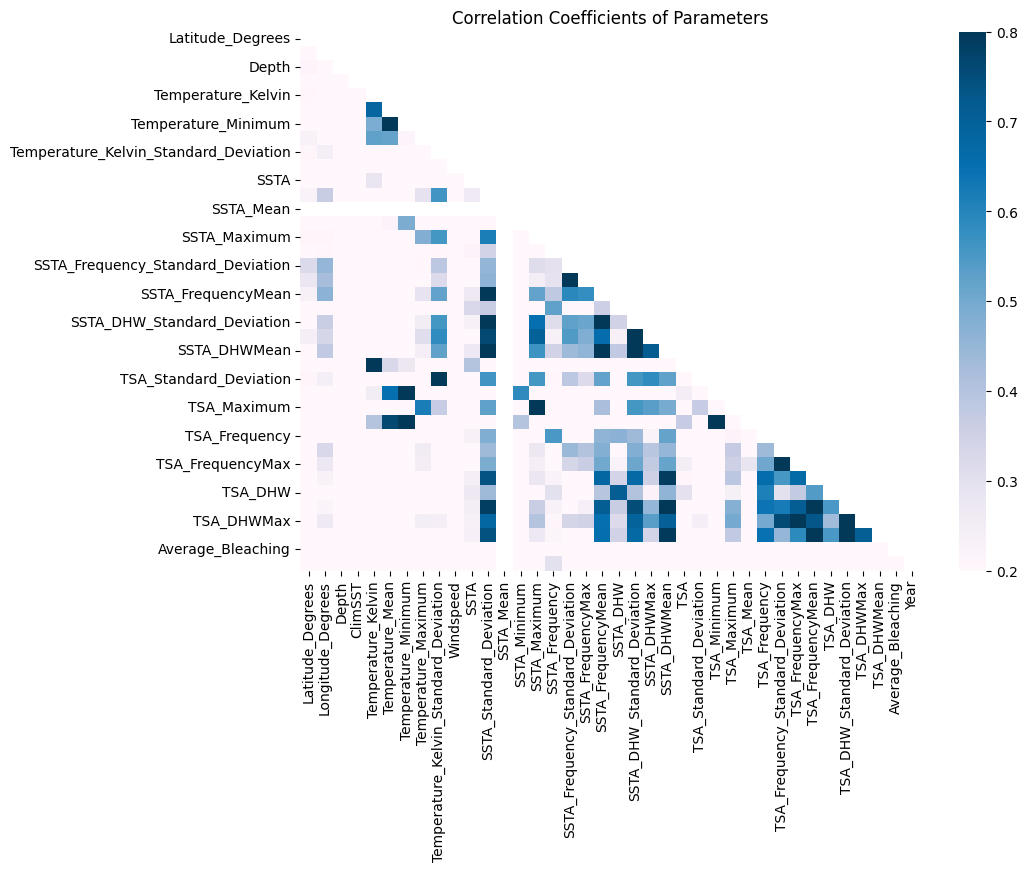

In [52]:
#calculate / chart correlation coefficients (pearson)
plt.figure(figsize=(10,7))
corr = df_coral.corr()


mask = np.triu(np.ones_like(df_coral.corr(), dtype=bool))

my_cmap = copy(plt.cm.PuBu)

sns.heatmap(corr, annot=False, mask=mask, vmin=.2, vmax=.8, cmap=my_cmap)

plt.title('Correlation Coefficients of Parameters')
plt.show()

## Charting correlation coefficients of parameters selected by Madireddy, et al.
This appears to replicate their results.

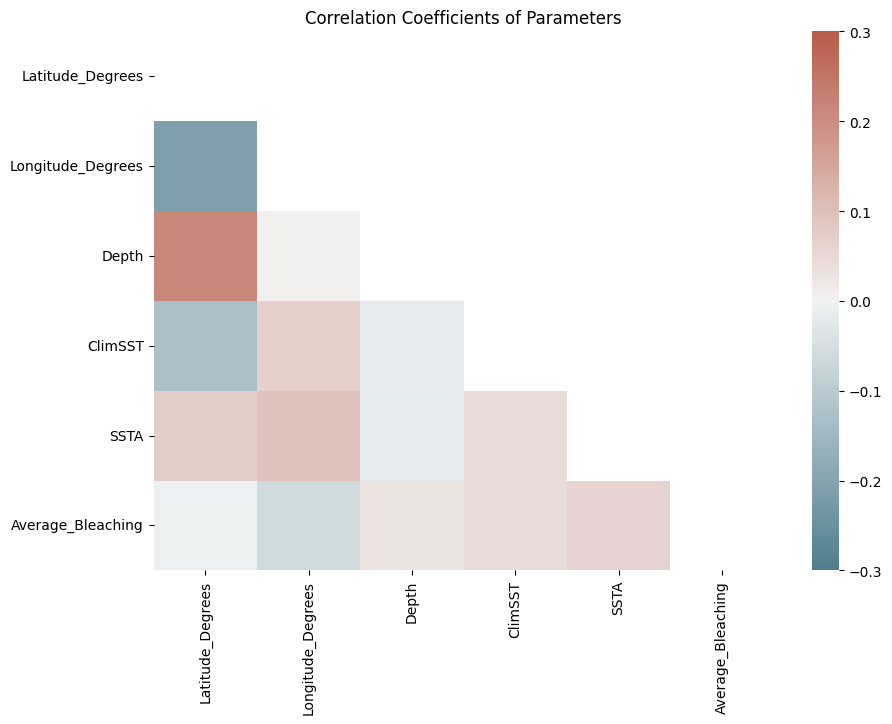

In [53]:
#correlation of selected parameters and target
selected_parameters = ['Latitude_Degrees', 'Longitude_Degrees', 'Depth', 'ClimSST', 'SSTA', 'Average_Bleaching']

# set figure size
plt.figure(figsize=(10,7))
corr = df_coral[selected_parameters].corr()

# Generate a mask to onlyshow the bottom triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# generate heatmap
sns.heatmap(corr, annot=False, mask=mask, vmin=-.3, vmax=.3, cmap=sns.diverging_palette(220, 20, s=60, as_cmap=True))
plt.title('Correlation Coefficients of Parameters')
plt.show()

## PCA
I was unable to achieve the same results as the authors. They were able to show a cumulative variance % reaching the 95% threshold between 3 and 4 components.

-4.838738162007954e-16
0.9860132971832694
[0.32735229 0.15871008 0.08414552 0.06099238 0.05566532] [0.32735229 0.48606237 0.57020789 0.63120027 0.68686559]


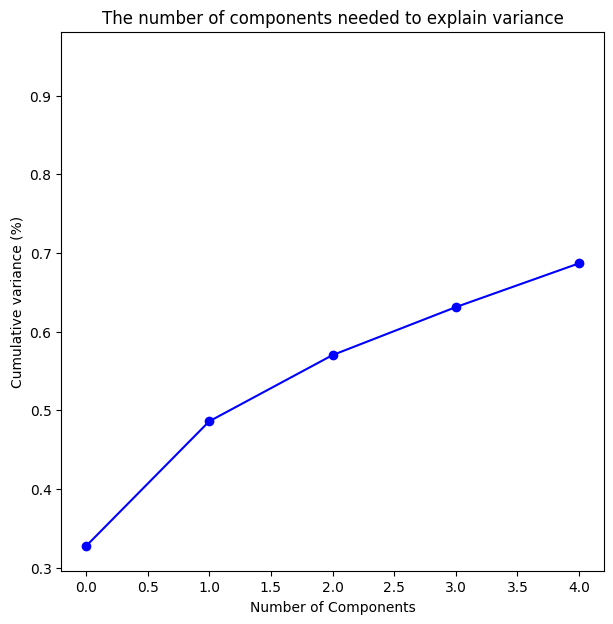

In [54]:
#create feature and target dfs; normalize features
features = ['Latitude_Degrees', 'Longitude_Degrees',
       'Depth', 'ClimSST', 'Temperature_Kelvin',
       'Temperature_Mean', 'Temperature_Minimum', 'Temperature_Maximum',
       'Temperature_Kelvin_Standard_Deviation', 'Windspeed', 'SSTA',
       'SSTA_Standard_Deviation',
       'SSTA_Mean', 'SSTA_Minimum', 'SSTA_Maximum',
       'SSTA_Frequency', 'SSTA_Frequency_Standard_Deviation',
       'SSTA_FrequencyMax', 'SSTA_FrequencyMean', 'SSTA_DHW',
       'SSTA_DHW_Standard_Deviation', 'SSTA_DHWMax', 'SSTA_DHWMean', 'TSA',
       'TSA_Standard_Deviation', 'TSA_Maximum', 'TSA_Mean',
       'TSA_Frequency', 'TSA_Frequency_Standard_Deviation', 'TSA_FrequencyMax',
       'TSA_FrequencyMean', 'TSA_DHW', 'TSA_DHW_Standard_Deviation',
       'TSA_DHWMax', 'TSA_DHWMean', 'Year']
x = pd.DataFrame(df_coral.loc[:, features].values)
x = StandardScaler().fit_transform(x)
y = pd.DataFrame(df_coral.loc[:, 'Average_Bleaching'])
x_0 = pd.DataFrame(df_coral.loc[:, features].values)

x.shape
print(np.mean(x))
print(np.std(x))

feat_cols = ['feature'+str(i) for i in range(x.shape[1])]
normalised_coral = pd.DataFrame(x,columns=feat_cols)
normalised_coral.tail()

pca = PCA(n_components=5)

df_pca = pd.DataFrame(pca.fit_transform(x))

# percentage of variance explained by each of the selected components.
individual_variances = pca.explained_variance_ratio_
cumulative_variances = np.cumsum(individual_variances)
print(individual_variances, cumulative_variances)

plt.figure(figsize=(7, 7))

# Create the line plot for cumulative variance
line = plt.plot(cumulative_variances, marker='o', linestyle='-', color='b')

threshold = plt.plot(.95, color = 'r')

# Aesthetics for the plot
plt.xlabel('Number of Components')
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')
plt.show()

## Create train and test datasets
80% train, 20% test

In [55]:
features = ['Latitude_Degrees', 'Longitude_Degrees', 'Windspeed', 'Depth',
            'TSA_Standard_Deviation', 'TSA', 'TSA_Mean', 'ClimSST', 'SSTA']
x_0 = pd.DataFrame(df_coral.loc[:, features].values)
x = pd.DataFrame(df_coral.loc[:, features].values)
x = StandardScaler().fit_transform(x)
y = pd.DataFrame(df_coral.loc[:, 'Average_Bleaching'])
X_train, X_test, y_train, y_test = train_test_split(x, y,test_size=.2,random_state =1)

# My Model Selection and Tuning

## Run LazyRegressor (from lazypredict)

In [56]:
reg = LazyRegressor(verbose=0,ignore_warnings=False, custom_metric=None )
models,predictions = reg.fit(X_train, X_test, y_train, y_test)

 21%|██▏       | 9/42 [00:04<00:16,  1.98it/s]

GammaRegressor model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.


 74%|███████▍  | 31/42 [00:49<00:13,  1.23s/it]

QuantileRegressor model failed to execute
Solver interior-point is not anymore available in SciPy >= 1.11.0.


100%|██████████| 42/42 [00:55<00:00,  1.32s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000472 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1894
[LightGBM] [Info] Number of data points in the train set: 4889, number of used features: 9
[LightGBM] [Info] Start training from score 2.861901


## Show LazyRegressor results
When the authors ran this, there were 39 regressors. There are 42 when I run it. This is evidence of updates to sklearn. Other packages have been updated as well over time.

In [57]:
models

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
RandomForestRegressor,0.34,0.34,6.90,3.51
BaggingRegressor,0.31,0.32,7.03,0.85
HistGradientBoostingRegressor,0.30,0.31,7.08,6.20
ExtraTreesRegressor,0.29,0.30,7.13,1.87
LGBMRegressor,0.29,0.29,7.17,0.18
XGBRegressor,0.24,0.24,7.42,0.33
GradientBoostingRegressor,0.19,0.20,7.61,1.82
MLPRegressor,0.07,0.07,8.20,12.53
KNeighborsRegressor,0.03,0.04,8.36,0.25


## Random Forest using features I selected using the correlation chart and the tuning from the author's git repo--This is the best result!
I tried to find a better tuning, but my manual and GridSearchCV searches did not improve on this. The only thing that did improve on it was adding features back in.

In [58]:
#est1 = RandomForestRegressor(warm_start=True, n_estimators=150, criterion="squared_error", bootstrap=True, oob_score=True, ).fit(X_train, y_train)
est1 = RandomForestRegressor(min_samples_leaf=3, max_features = 'sqrt', max_depth = 16, criterion = 'friedman_mse',
                             bootstrap = False, n_estimators = 300, random_state = 42).fit(X_train, y_train)
train_score = est1.score(X_train, y_train)
test_score = est1.score(X_test, y_test)
y_pred1 = est1.predict(X_test)
test_mse1= metrics.mean_squared_error(y_test, y_pred1)
test_rmse1 = np.sqrt(test_mse1)
test_mae1 = metrics.mean_absolute_error(y_test, y_pred1)
test_r2_1 = metrics.r2_score(y_test, y_pred1)
print("Train Score %.4f, Test Score %.4f, Test MAE %.4f, MSE %.4f, RMSE %.4f, r2 %.4f" % (train_score, test_score, test_mae1, test_mse1, test_rmse1, test_r2_1))

Train Score 0.7808, Test Score 0.4031, Test MAE 2.9958, MSE 43.2951, RMSE 6.5799, r2 0.4031


## Random Forest using the features and tuning from the file in the author's git repo
Produces the following results:
Train Score 0.7483, Test Score 0.3283, Test MAE 3.1233, MSE 48.7224, RMSE 6.9801, r2 0.3283

They state in the paper that this was 96% accurate, but I cannot see how they got that.

In their git repo, their train_test_split has test_size set to 0.3, but the paper indicates it should be 0.2. The git repo's setting does produce a better result.

In [59]:
features = ['Latitude_Degrees', 'Longitude_Degrees', 'Depth','ClimSST', 'SSTA']

x_0 = pd.DataFrame(df_coral.loc[:, features].values)
x = pd.DataFrame(df_coral.loc[:, features].values)
x = StandardScaler().fit_transform(x)
y = pd.DataFrame(df_coral.loc[:, 'Average_Bleaching'])
X_train, X_test, y_train, y_test = train_test_split(x, y,test_size=.2,random_state =1)

est2 = RandomForestRegressor(min_samples_leaf=3, max_features = 'sqrt', max_depth = 16, criterion = 'friedman_mse', bootstrap = False, n_estimators = 300, random_state = 42).fit(X_train, y_train)
train_score = est2.score(X_train, y_train)
test_score = est2.score(X_test, y_test)
y_pred1 = est2.predict(X_test)
test_mse1= metrics.mean_squared_error(y_test, y_pred1)
test_rmse1 = np.sqrt(test_mse1)
test_mae1 = metrics.mean_absolute_error(y_test, y_pred1)
test_r2_1 = metrics.r2_score(y_test, y_pred1)
print("Train Score %.4f, Test Score %.4f, Test MAE %.4f, MSE %.4f, RMSE %.4f, r2 %.4f" % (train_score, test_score, test_mae1, test_mse1, test_rmse1, test_r2_1))

Train Score 0.7483, Test Score 0.3283, Test MAE 3.1233, MSE 48.7224, RMSE 6.9801, r2 0.3283


## LazyRegressor run using the authors' features

In [60]:
reg = LazyRegressor(verbose=0,ignore_warnings=False, custom_metric=None )
models,predictions = reg.fit(X_train, X_test, y_train, y_test)

 21%|██▏       | 9/42 [00:01<00:07,  4.49it/s]

GammaRegressor model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.


 74%|███████▍  | 31/42 [00:21<00:06,  1.59it/s]

QuantileRegressor model failed to execute
Solver interior-point is not anymore available in SciPy >= 1.11.0.


100%|██████████| 42/42 [00:28<00:00,  1.48it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1132
[LightGBM] [Info] Number of data points in the train set: 4889, number of used features: 5
[LightGBM] [Info] Start training from score 2.861901


In [61]:
models

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
HistGradientBoostingRegressor,0.27,0.27,7.28,1.84
RandomForestRegressor,0.24,0.25,7.40,3.06
LGBMRegressor,0.23,0.23,7.47,0.13
ExtraTreesRegressor,0.22,0.22,7.52,0.86
BaggingRegressor,0.21,0.21,7.56,0.26
GradientBoostingRegressor,0.20,0.20,7.60,1.01
XGBRegressor,0.17,0.17,7.75,0.26
MLPRegressor,0.04,0.05,8.32,5.30
RidgeCV,0.01,0.01,8.47,0.05


## One of my main failed attemps to tune a model using GridSearchCV

In [62]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import HistGradientBoostingRegressor
#Convert to dictionary
hyperparameters = {'loss': ('squared_error','ablosulte_error'), 'learning_rate':(.01, .1, .2),
                   'max_iter':(100,150,200),'max_leaf_nodes':(31, 10)}
#Create new reg object
hgb_tune = HistGradientBoostingRegressor()
#Use GridSearch
reg1 = GridSearchCV(hgb_tune, hyperparameters, cv=10)
best_model1 = reg1.fit(X_train, y_train)
train_score = best_model1.score(X_train, y_train)
test_score = best_model1.score(X_test, y_test)
print(train_score, test_score)

0.6372048270274617 0.28287011322064737
